# predictions
---

this notebook explores the output of the SSIM net and how its predictions compare to the actual SSIM data. we will also explore some of the filters that the network has learned and see what they look like.

In [1]:
import numpy as np
import pandas as pd
import scipy.signal as sig
import matplotlib.pyplot as plt
import iqa_tools as iqa
import matplotlib.gridspec as gridspec
import tensorflow as tf

In [2]:
image_dim, result_dim = 96, 86
input_layer, output_layer = 4, 1
input_layer, first_layer, second_layer, third_layer, fourth_layer, output_layer = 4, 100, 50, 25, 10, 1
filter_dim, filter_dim2 = 11, 1

read in the data files

In [3]:
# data input
data_path = 'https://raw.githubusercontent.com/michaelneuder/image_quality_analysis/master/data/sample_data/'

# train data --- 500 images, 96x96 pixels
orig_500 = pd.read_csv('{}orig_500.txt'.format(data_path), header=None, delim_whitespace = True)
recon_500 = pd.read_csv('{}recon_500.txt'.format(data_path), header=None, delim_whitespace = True)

# test data --- 140 images, 96x96 pixels
orig_140 = pd.read_csv('{}orig_140.txt'.format(data_path), header=None, delim_whitespace = True)
recon_140 = pd.read_csv('{}recon_140.txt'.format(data_path), header=None, delim_whitespace = True)

# train target --- 500 images, 86x86 pixels (dimension reduction due no zero padding being used)
ssim_500 = pd.read_csv('{}ssim_500_nogauss.csv'.format(data_path), header=None)
ssim_140 = pd.read_csv('{}ssim_140_nogauss.csv'.format(data_path), header=None)

In [4]:
# getting 4 input channels for train and test --- (orig, recon, orig squared, recon squared)
original_images_train = orig_500.values
original_images_train_sq = orig_500.values**2
reconstructed_images_train = recon_500.values
reconstructed_images_train_sq = recon_500.values**2

original_images_test = orig_140.values
original_images_test_sq = orig_140.values**2
reconstructed_images_test = recon_140.values
reconstructed_images_test_sq = recon_140.values**2

# stack inputs
training_input = np.dstack((original_images_train, reconstructed_images_train, original_images_train_sq, reconstructed_images_train_sq))
testing_input = np.dstack((original_images_test, reconstructed_images_test, original_images_test_sq, reconstructed_images_test_sq))

# normalize inputs
training_input_normalized, testing_input_normalized = iqa.normalize_input(training_input, testing_input)

# target values
training_target = ssim_500.values
testing_target = ssim_140.values

In [5]:
# get size of training and testing set
train_size = original_images_train.shape[0]
test_size = original_images_test.shape[0]

# reshaping features to (num images, 96x96, 4 channels)
train_features = np.reshape(training_input_normalized, [train_size,image_dim,image_dim,input_layer])
test_features =  np.reshape(testing_input_normalized, [test_size,image_dim,image_dim,input_layer])

# reshaping target to --- (num images, 86x86, 1)
train_target = np.reshape(training_target, [train_size, result_dim, result_dim, output_layer])
test_target = np.reshape(testing_target, [test_size, result_dim, result_dim, output_layer])

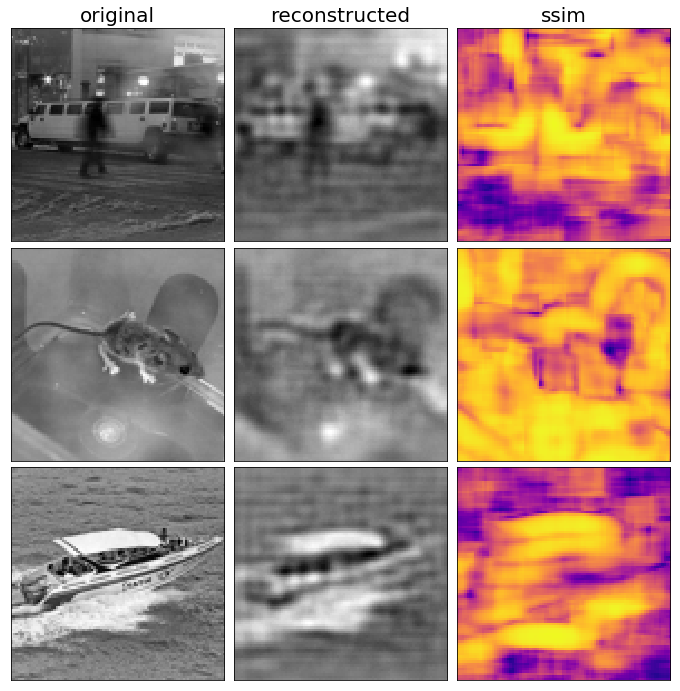

In [6]:
plt.figure(figsize = (12,12))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0, hspace=0.03)

for i in range(3):
    x = np.random.randint(500)
    ax1, ax2, ax3 = plt.subplot(gs1[3*i]), plt.subplot(gs1[3*i+1]), plt.subplot(gs1[3*i+2])
    for ax in [ax1, ax2, ax3]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if i == 0:
        ax1.set_title('original', size=20)
        ax2.set_title('reconstructed', size=20)
        ax3.set_title('ssim', size=20)
        
    ax1.imshow(train_features[x,:,:,0], cmap='gray')
    ax2.imshow(train_features[x,:,:,1], cmap='gray')
    ax3.imshow(train_target[x,:,:,0], cmap='plasma')
plt.show()

ok now that we have all the data in place we need to load the current weights learned by the network.

In [7]:
weights = {}; biases = {};
for entry in ['weights1', 'weights2', 'weights3', 'weights4', 'weights_out']:
    temp = np.loadtxt('weights/{}.txt'.format(entry))
    weights[entry] = temp
for entry in ['bias1', 'bias2', 'bias3', 'bias4', 'bias_out']:
    temp = np.loadtxt('weights/{}.txt'.format(entry))
    biases[entry] = temp

In [8]:
weights['weights1'] = weights['weights1'].reshape((filter_dim,filter_dim,input_layer,first_layer))
weights['weights2'] = weights['weights2'].reshape((filter_dim2,filter_dim2,first_layer,second_layer))
weights['weights3'] = weights['weights3'].reshape((filter_dim2,filter_dim2,second_layer,third_layer))
weights['weights4'] = weights['weights4'].reshape((filter_dim2,filter_dim2,third_layer,fourth_layer))
weights['weights_out'] = weights['weights_out'].reshape((filter_dim2,filter_dim2,fourth_layer+third_layer+second_layer+first_layer,output_layer))

In [9]:
biases['bias1'] = biases['bias1'].reshape((first_layer))
biases['bias2'] = biases['bias2'].reshape((second_layer))
biases['bias3'] = biases['bias3'].reshape((third_layer))
biases['bias4'] = biases['bias4'].reshape((fourth_layer))
biases['bias_out'] = biases['bias_out'].reshape((output_layer))

In [10]:
for weight in weights:
    print(weights[weight].shape)
for bias in biases:
    print(biases[bias].shape)

(11, 11, 4, 100)
(1, 1, 100, 50)
(1, 1, 50, 25)
(1, 1, 25, 10)
(1, 1, 185, 1)
(100,)
(50,)
(25,)
(10,)
(1,)


ok now we have all the filters loaded in lets look at a couple for kicks.

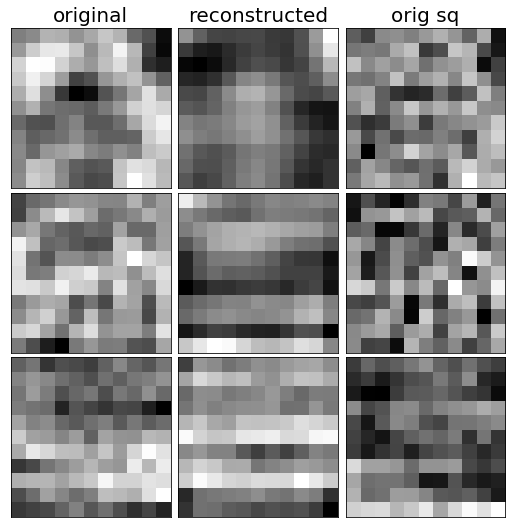

In [11]:
plt.figure(figsize = (9,9))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0, hspace=0.03)

for i in range(3):
    ax1, ax2, ax3 = plt.subplot(gs1[3*i]), plt.subplot(gs1[3*i+1]), plt.subplot(gs1[3*i+2])
    for ax in [ax1, ax2, ax3]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
    if i == 0:
        ax1.set_title('original', size=20)
        ax2.set_title('reconstructed', size=20)
        ax3.set_title('orig sq', size=20)
        
    x = np.random.randint(100)
    ax1.imshow(weights['weights1'][:,:,0,x], cmap='gray')
    ax2.imshow(weights['weights1'][:,:,1,x], cmap='gray')
    ax3.imshow(weights['weights1'][:,:,2,x], cmap='gray')
plt.show()

cool looking i guess. now lets convolve some images.

In [20]:
def convolve_inner_layers(x, W, b):
    '''
    inner layers of network --- tanh activation
    '''
    y = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='VALID')
    y = tf.nn.bias_add(y, b)
    return tf.nn.tanh(y)

def convolve_ouput_layer(x, W, b):
    '''
    output layer of network --- linear activation
    '''
    y = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='VALID')
    y = tf.nn.bias_add(y, b)
    return y

def conv_net(x, W, b):
    '''
    entire conv net. each layer feed to following layer as well as output layer
    '''
    conv1 = convolve_inner_layers(x, W['weights1'], b['bias1'])
    conv2 = convolve_inner_layers(conv1, W['weights2'], b['bias2'])
    conv3 = convolve_inner_layers(conv2, W['weights3'], b['bias3'])
    conv4 = convolve_inner_layers(conv3, W['weights4'], b['bias4'])
    output_feed = tf.concat([conv1, conv2, conv3, conv4],3)
    output = convolve_ouput_layer(output_feed, W['weights_out'], b['bias_out'])
    return output

In [13]:
test_features.shape

(140, 96, 96, 4)

In [ ]:
sess = tf.Session()
prediction = sess.run(conv_net(tf.cast(test_features, 'float32'), weights, biases))

In [22]:
prediction.shape

TensorShape([Dimension(140), Dimension(86), Dimension(86), Dimension(1)])

In [ ]:
plt.figure(figsize = (12,12))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0, hspace=0.03)

for i in range(3):
    x = np.random.randint(500)
    ax1, ax2, ax3 = plt.subplot(gs1[3*i]), plt.subplot(gs1[3*i+1]), plt.subplot(gs1[3*i+2])
    for ax in [ax1, ax2, ax3]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if i == 0:
        ax1.set_title('original', size=20)
        ax2.set_title('reconstructed', size=20)
        ax3.set_title('ssim', size=20)
        
    ax1.imshow(train_features[x,:,:,0], cmap='gray')
    ax2.imshow(train_features[x,:,:,1], cmap='gray')
    ax3.imshow(train_target[x,:,:,0], cmap='plasma')
plt.show()